# Imports and configs

In [1]:
!uv pip install -q --system autogluon scikit-learn==1.5.2

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import os

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42
    time_limit = 3600 * 10

# Loading data and defining folds

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

# Fitting the predictor

In [6]:
%%writefile custom_metric.py

from autogluon.core.metrics import make_scorer
import numpy as np

def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

ag_map3 = make_scorer(
    name='map3',
    score_func=map3,
    optimum=1,
    needs_proba=True,
    greater_is_better=True
)

Writing custom_metric.py


In [7]:
from custom_metric import ag_map3

predictor = TabularPredictor(
    path="/logs",
    problem_type="multiclass",
    eval_metric=ag_map3,
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [8]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality",
    excluded_model_types = ["KNN"]
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.07 GB / 31.35 GB (95.9%)
Disk Space Avail:   1701.58 GB / 8062.39 GB (21.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect st

(_ray_fit pid=1691) [1000]	valid_set's multi_logloss: 1.92466	valid_set's map3: 0.321619


(_ray_fit pid=1691) 	Ran out of time, early stopping on iteration 1085. Best iteration is: [repeated 4x across cluster]
(_ray_fit pid=1691) 	[1072]	valid_set's multi_logloss: 1.92448	valid_set's map3: 0.322124 [repeated 4x across cluster]
(_dystack pid=266) 	0.32	 = Validation score   (map3)
(_dystack pid=266) 	3979.71s	 = Training   runtime
(_dystack pid=266) 	790.08s	 = Validation runtime
(_dystack pid=266) Fitting model: LightGBM_BAG_L1 ... Training model for up to 618.51s of the 3617.04s of remaining time.
(_dystack pid=266) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.05%)
(_ray_fit pid=2257) 	Ran out of time, early stopping on iteration 68. Best iteration is:
(_ray_fit pid=2257) 	[68]	valid_set's multi_logloss: 1.93027	valid_set's map3: 0.314733
(_ray_fit pid=2448) 	Ran out of time, early stopping on iteration 135. Best iteration is: [repeated 4x across cluster]
(_ray_fit pid=2448) 	[135]	valid_set

In [9]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.329121,map3,3319.423191,19209.535097,2.423349,827.758416,3,True,14
1,LightGBMXT_BAG_L2,0.328979,map3,3284.857179,17551.057873,27.318878,672.899370,2,True,8
2,LightGBM_BAG_L2,0.328751,map3,3282.363578,17560.668884,24.825277,682.510381,2,True,9
3,WeightedEnsemble_L2,0.328723,map3,3239.029476,16071.910167,2.585737,855.398417,2,True,6
4,CatBoost_BAG_L2,0.327065,map3,3258.395606,17514.665069,0.857304,636.506566,2,True,12
5,XGBoost_BAG_L2,0.326889,map3,3264.855687,17026.366930,7.317386,148.208427,2,True,13
6,NeuralNetFastAI_BAG_L2,0.325792,map3,3270.329513,18345.514259,12.791212,1467.355756,2,True,7
7,LightGBMXT_BAG_L1,0.325698,map3,3032.414935,13564.903548,3032.414935,13564.903548,1,True,2
8,LightGBM_BAG_L1,0.325533,map3,204.028805,1651.608202,204.028805,1651.608202,1,True,3
9,RandomForestGini_BAG_L2,0.324020,map3,3312.299510,19612.262586,54.761208,2734.104083,2,True,10


In [10]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

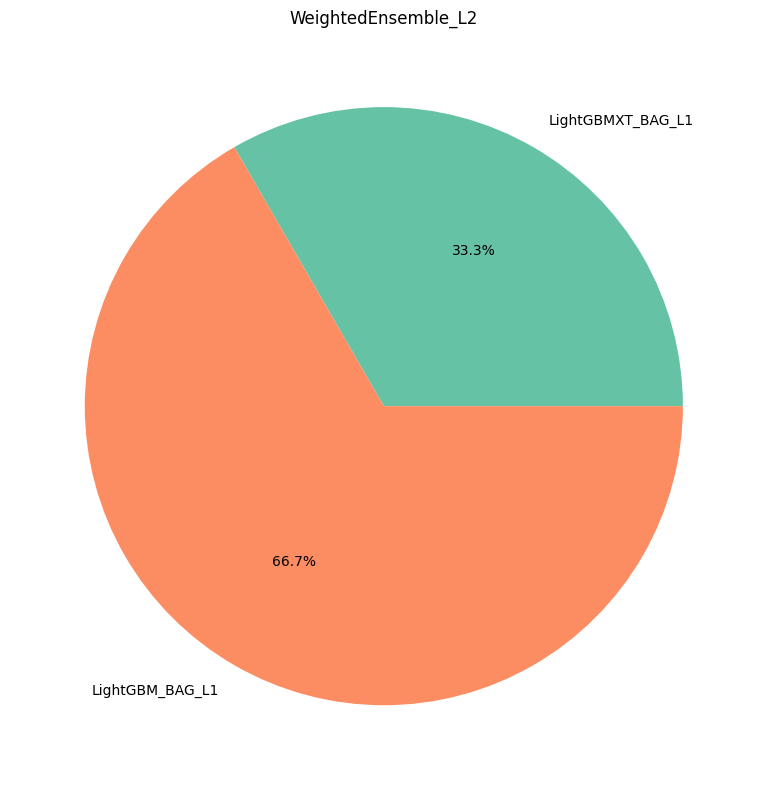

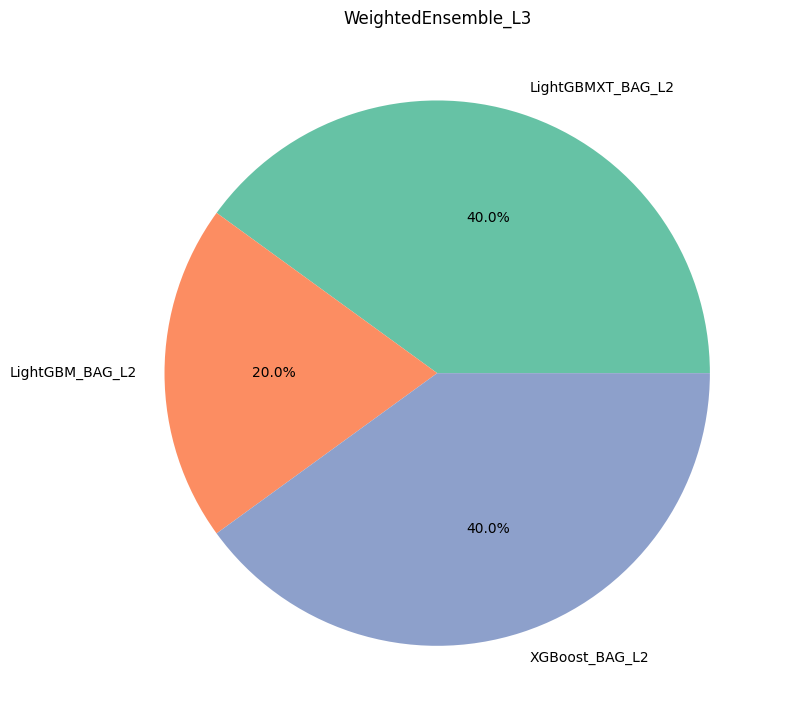

In [11]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(8, 8))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Saving OOF files and creating a submission file

In [12]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = "oof_pred_probs" if type == "oof" else "test_pred_probs"
    base_path = "." if is_ensemble else base_path
    with open(f"{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl", "wb") as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    final_predictions = []
    for i in np.argsort(test_pred_probs, axis=1)[:, -3:][:, ::-1]:
        prediction = label_encoder.inverse_transform(i)
        final_predictions.append(" ".join(prediction))
        
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = final_predictions
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_pred_probs", exist_ok=True)
os.makedirs("test_pred_probs", exist_ok=True)

In [13]:
oof_pred_probs = {}
test_pred_probs = {}

In [14]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [15]:
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values
    model_test_pred_probs = test_pred_probs[model].values
    
    cv_score = map3(train[CFG.target], model_oof_pred_probs)
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, "oof", False)
        save_pred_probs(model_test_pred_probs, cv_score, model, "test", False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, "oof", True)
        save_pred_probs(model_test_pred_probs, cv_score, model, "test", True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

# Visualizing the results

In [16]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = map3(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

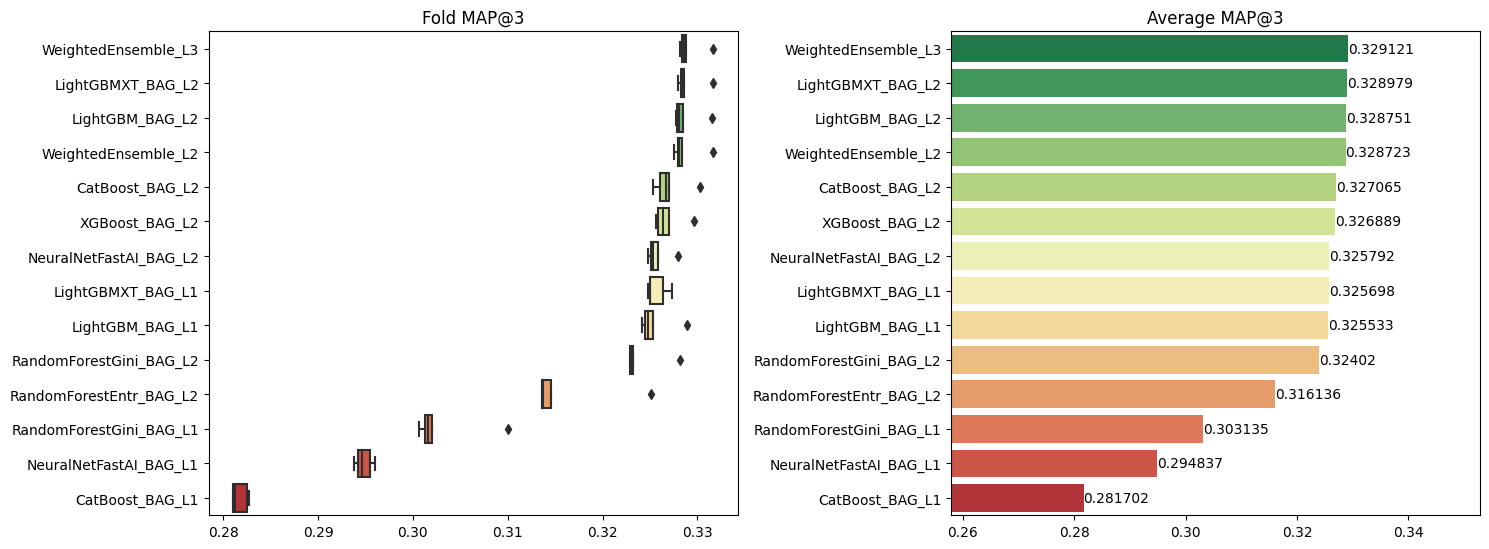

In [17]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title("Average MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()